<a href="https://colab.research.google.com/github/ntnhan54/GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: thnhnhnnguyn
Your Kaggle Key: ··········


  2%|▏         | 8.00M/395M [00:00<00:05, 76.7MB/s]

100%|██████████| 395M/395M [00:02<00:00, 190MB/s]


In [3]:
import os
DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
trans = T.Compose([
                   T.Resize(image_size),
                   T.CenterCrop(image_size),
                   T.ToTensor(),
                   T.Normalize(*stats)
])

In [7]:
train_ds = ImageFolder(DATA_DIR, transform=trans)
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [8]:
def denorm(img_tensor):
  return img_tensor * stats[1][0] + stats[0][1]

In [9]:
def show_images(images, nmax = 64):
  fig, ax = plt.subplots(figsize = (8,8))
  ax.set_xticks([]); ax.set_yticks([]);
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow = 8).permute(1,2,0))

def show_batch(dl, nmax = 64):
  for images, _ in dl:
    show_images(images,nmax)
    break

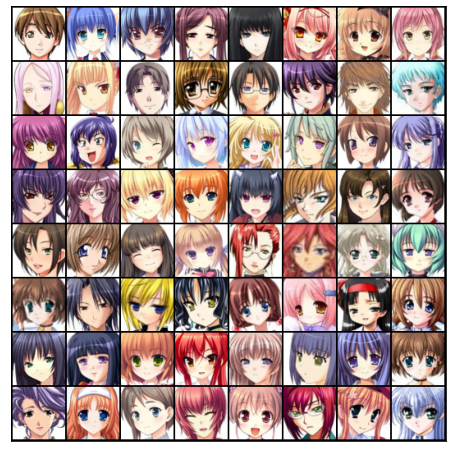

In [10]:
show_batch(train_dl)

# Wrap Device Dataloader

In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def to_device(data, device):
  if device == torch.device('cpu'):
    return
  if isinstance(data, (list, tuple)):
    return (to_device(x,device) for x in data)
  return data.to(device, non_blocking = True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)
  def __len__(self):
    return len(self.dl)

In [12]:
train_dl = DeviceDataLoader(train_dl, device)

In [13]:
import torch.nn as nn
import torch.functional as F
from torchvision.utils import save_image
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [35]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
os.makedirs('gif', exist_ok=True)

In [15]:
def save_samples(index, latent_tensors, show = True):
  fake_images = generator(latent_tensors)
  fake_fname = 'generated-image-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print(f'Saving {fake_fname}')
  if show:
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [16]:
discriminator = nn.Sequential(
                  # input shape: (3,64,64)
                  nn.Conv2d(3, 64, kernel_size = 4, stride = 2, padding=1, bias = False),
                  nn.BatchNorm2d(64),
                  nn.LeakyReLU(0.2, inplace=True),

                  # out: 64,32,32
                  nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding=1, bias = False),
                  nn.BatchNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True),
                  
                  # out: 128,32,32
                  nn.Conv2d(128, 256, kernel_size = 4, stride = 2, padding=1, bias = False),
                  nn.BatchNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True),
                  
                  # out: 256,32,32
                  nn.Conv2d(256, 512, kernel_size = 4, stride = 2, padding=1, bias = False),
                  nn.BatchNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True),
                  
                  # out: 512,32,32
                  nn.Conv2d(512, 1, kernel_size = 4, stride = 1, padding = 0, bias = False),
                  
                  # out: 1,1,1
                  nn.Flatten(),
                  nn.Sigmoid()
                )

In [17]:
discriminator = to_device(discriminator, device)

In [18]:
latent_size = 128

In [19]:
generator = nn.Sequential(
    #in: latent_size x 1 x 1
    
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias = False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128,16,16
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias = False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32
    nn.ConvTranspose2d(64, 3, kernel_size = 4, stride = 2, padding = 1, bias = False),
    nn.Tanh()
    # out: 3,64,64
)

In [20]:
# xb = torch.randn(batch_size, latent_size, 1, 1)
# fake_images = generator(xb)
# print(fake_images.shape)
# show_images(fake_images)

In [21]:
generator = to_device(generator, device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-image-0000.png


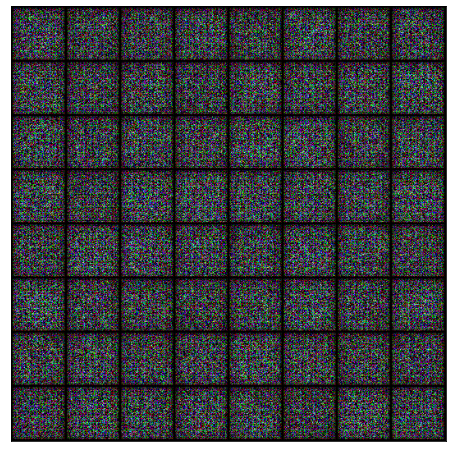

In [22]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [23]:
def train_discriminator(real_images, opt_d):
  opt_d.zero_grad()
  
  # pass real images throught discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.shape[0],1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # generate fake images

  latent = torch.randn(batch_size, latent_size, 1, 1, device = device)
  fake_images = generator(latent)

  # Pass fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device = device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
  # clear generator gradient
  opt_g.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1,1, device = device)
  fake_images = generator(latent)
  
  # try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device = device)
  loss = F.binary_cross_entropy(preds, targets)

  # update weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [25]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # losses & scores
  losses = {'discriminator': [],
            'generator': []
          }
  scores = {
      'real' : [],
      'fake': []
  }

  # create optimizers

  opt_d = torch.optim.Adam(discriminator.parameters(), lr = lr,betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr = lr,betas=(0.5, 0.999))
  
  pbar = tqdm(range(epochs))
  for epoch in pbar:
    for real_images, _ in tqdm(train_dl):
      # train discriminator
      # print('d')
      loss_d, real_score, fake_score = train_discriminator(real_images,opt_d)
      # train generator
      # print('g')
      loss_g = train_generator(opt_g)

    losses['generator'].append(loss_g)
    losses['discriminator'].append(loss_d)
    scores['real'].append(real_score)
    scores['fake'].append(fake_score)
    
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)
    pbar.set_postfix({'real_score': real_score, 'fake_score': fake_score})


  return losses, scores

In [34]:
import glob
from PIL import Image

# filepaths
fp_in = "generated/*"
# fp_out = "gif/" + str(epochs) + "epochs.gif"

def save_gif(epochs, p_in = sample_dir, p_out = 'gif'):
  fp_in = p_in + '/*.png'
  img, *imgs = [Image.open(f) for f in sorted(glob.glob(fp_in))]
  fp_out = p_out + f'{epochs}epochs.gif'
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=250, loop=0)

In [26]:
lr = 0.0002
epochs = 25

In [27]:
history = fit(epochs, lr)


Saving generated-image-0001.png



Saving generated-image-0002.png



Saving generated-image-0003.png


KeyboardInterrupt: ignored

In [ ]:
lr = 0.001
epochs = 25
history += fit(epochs, lr, start_idx = 26)

In [ ]:
losses = history[0]
plt.plot(losses['discriminator'], '-')
plt.plot(losses['generator'], '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['discriminator', 'generator'])
plt.title('Losses');

In [ ]:
scores = history[-1]
plt.plot(scores['real'], '-')
plt.plot(scores['fake'], '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');